# Second experiment
## Everything as before but with a different dataset (mnist instead of fashion-mnist)


In this experiment we are going to test the robustness of neural networks in a very basic configuration, using Activation Function in the hidden layer as a changing parameter.
The constant characteristics of the networks are:
* Dataset = mnist
* Loss = cathegorical crossentropy
* Output activation = softmax
* Number of hidden layers = 1
* Early stopping metric =  val_loss with patience 10

After having our models correctly set up, we are going to attack them and measure their robustness according to some metrics (before and after attack):
* Accuracy
* Precision
* Recall
* Max and min confidence
* Confusion matrix
* Most and least robust class


## Imports

In [1]:
from functions import *
import time
import gc
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Model

### Data Load and Preprocessing

In [2]:
# load data
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.astype("float32") / 255
test_images = test_images.astype("float32") / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print("Train set: ", train_images.shape)
print("Test set: ", test_images.shape)

# divide data into classes
subsets = []
n_classes = 10
for i in range(n_classes):
    tmp_list = []
    for j in range(test_images.shape[0]):
        c = np.nonzero(test_labels[j])[0][0]
        if c == i:
            tmp_list.append(test_images[j])
    tmp_list = np.array(tmp_list)
    subsets.append(tmp_list)
# now we have subsets which is a 10-elements list containing arrays of same class images

new_test_images = np.zeros((0,28,28))
for i in range(len(subsets)):
    new_test_images = np.concatenate((new_test_images, subsets[i]))
# now we have new_test_images which is test_images sorted by class

new_test_labels = np.zeros((0,n_classes))
for i in range(n_classes):
    tmp = np.zeros((subsets[i].shape[0],n_classes))
    tmp[:,i] = 1
    new_test_labels = np.concatenate((new_test_labels, tmp))
# now we have new_test_labels which is test_labels sorted to fit subsets

Train set:  (60000, 28, 28)
Test set:  (10000, 28, 28)


### Build and Train Models

In [ ]:
for function, initializer in DEEP_ACTIVATION.items():
    network = models.Sequential()
    network.add(layers.Flatten())
    network.add(layers.Dense(DEEP_NEURONS,activation=function,input_shape=INPUT_SHAPE,kernel_initializer=initializer,))
    network.add(layers.Dense(10, activation=OUT_ACTIVATION))
    network.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

    print(f'Network training with ativation function = "{function}"')

    es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=ES_PATIENCE)
    path = MODELS_PATH+"/best_" + function + ".h5"
    mc = ModelCheckpoint(filepath=path, monitor="val_loss", mode="min", save_best_only=True)
    cb_list = [es, mc]

    h = network.fit(train_images,train_labels,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=VALIDATION_SPLIT,callbacks=cb_list)

    # At this point we have best models saved in "best_models" folder

### Model Metrics Evaluation

In [ ]:
for function, initializer in DEEP_ACTIVATION.items():
    print(f'Evaluate model with hidden activation function "{function}"...')
    name = MODELS_PATH+"/best_" + function + ".h5"
    model = load_model(name)
    metrics_name = "scores_best_"+function
    m = ModelMetrics(metrics_name, new_test_images, new_test_labels, model.predict(new_test_images))
    m.buil_metrics()
    path = SCORES_PATH+"/"+metrics_name
    save_object(m, path)

## Attack

The attack consists of these steps:
1. select the model
2. take the test set and, for each class, find the most vulnerable pixel and the corresponding value (i.e. x,y,z)
3. modify the entire test set changing the pixel values found in the previous step
4. evaluate all the metrics of the selected model with the modified test set


### Prepare Attack

In [5]:
def objective(trial, m, test, current_class):

    xp = trial.suggest_int("xp", MIN_XP, MAX_XP)
    yp = trial.suggest_int("yp", MIN_YP, MAX_XP)
    value = trial.suggest_uniform("zp", MIN_ZP, MAX_ZP)

    new_test_labels = np.zeros((test.shape[0],10))
    new_test_labels[:,current_class] = 1

    tmp = np.copy(test)
    tmp[:,xp,yp] = value

    # minimize loss

    return m.evaluate(tmp,new_test_labels, verbose=0)[1]

def print_best_callback(study, trial):
    print(f"#Trial: {trial.number}, Best value: {study.best_value}, Best params: {study.best_trial.params}")

### Perform Attack

In [ ]:
start_time = time.time()

for function, initializer in DEEP_ACTIVATION.items(): # 7
    model_name = MODELS_PATH+"/best_" + function + ".h5"
    model = load_model(model_name)
    new_attacked_test_images = np.zeros((0,28,28))
    for i in CLASS_NAMES: # 10

        if not VERBOSITY:
            optuna.logging.set_verbosity(optuna.logging.WARNING)

        func = lambda trial: objective(trial, model, subsets[i], i)

        study_name = f"study_{function}_{i}"
        storage_name = f"sqlite:///{STUDY_DB_PATH}/{study_name}.db"
        study = optuna.create_study(study_name=study_name, storage=storage_name,direction=DIRECTION, sampler=SAMPLER)
        study.optimize(func, n_trials=N_TRIALS, timeout=TIMEOUT, callbacks=[print_best_callback])

# 2048 = 42006.023540496826 seconds = 11.6 hours
print("--- %s seconds ---" % (time.time() - start_time))

### Visualize Attack

#### Data preparation

In [ ]:
for function, initializer in DEEP_ACTIVATION.items():
    accuracy_trend = {0:load_object(SCORES_PATH+"/scores_best_"+function).accuracy}
    for c in range(N_CHECKPOINTS):
        attacked_test_images = np.zeros((0,28,28))
        x = (c+1)*int((N_TRIALS/N_CHECKPOINTS))
        for i in CLASS_NAMES:
            study_name = f"study_{function}_{i}"
            storage_name = f"sqlite:///{STUDY_DB_PATH}/{study_name}.db"
            study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)
            df = study.trials_dataframe(attrs=("value", "params"))

            idx = df['value'].head(x).idxmin()

            xp = df['params_xp'][idx]
            yp = df['params_yp'][idx]
            zp = df['params_zp'][idx]

            sub_attacked_test_images = np.copy(subsets[i])
            sub_attacked_test_images[:,xp,yp] = zp
            attacked_test_images = np.concatenate((attacked_test_images, sub_attacked_test_images))
        # here we have attacked_test_images correctly built
        metrics_name = "acc_trend_"+function
        name = MODELS_PATH+"/best_" + function + ".h5"
        model = load_model(name)
        m = ModelMetrics(metrics_name, attacked_test_images, new_test_labels, model.predict(attacked_test_images))
        m.buil_metrics()
        if c==(N_CHECKPOINTS-1):
            path = SCORES_PATH+"/scores_best_"+function+"_best_attack"
            save_object(m, path)
        accuracy_trend[x] = m.accuracy
        del m
        gc.collect()
    path = SCORES_PATH+"/"+metrics_name
    save_object(accuracy_trend, path)
    # here we have saved attacked models metrics for each checkpoint for one function

#### Table "functions vs classes" of attack surface (objective function value)

In [ ]:
plt.rcParams["figure.figsize"] = (10, 8)
for function, initializer in DEEP_ACTIVATION.items():
    for i in CLASS_NAMES:
        study_name = f"study_{function}_{i}"
        storage_name = f"sqlite:///{STUDY_DB_PATH}/{study_name}.db"
        study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)
        fig = optuna.visualization.matplotlib.plot_contour(study, params=['xp', 'yp'], target_name='')
        fig.invert_yaxis()
        fig.set_title(f"Function="+r"$\bf{" + function + "}$"+", Class="+r"$\bf{" + CLASS_NAMES[i] + "}$", fontsize=20)
        path = f"{ATTACK_SURFACE_F_FIG_PATH}/attack_surface_f_{function}_{i}.png"
        plt.savefig(path)

#### Table "functions vs classes" of attack surface (modified pixel value)

In [ ]:
for function, initializer in DEEP_ACTIVATION.items():
    for i in CLASS_NAMES:

        study_name = f"study_{function}_{i}"
        storage_name = f"sqlite:///{STUDY_DB_PATH}/{study_name}.db"
        study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)
        df = study.trials_dataframe(attrs=("value", "params"))
        df = df.groupby(['params_xp','params_yp', 'params_zp'], as_index=False)['value'].min()
        df = df.groupby(['params_xp','params_yp', ], as_index=False)['params_zp'].min()

        data1 = np.zeros((28,28))
        for index, row in df.iterrows():
            data1[int(row['params_xp']),int(row['params_yp'])] = row['params_zp']

        data2 = np.mean(np.array(subsets[i]),axis=0)

        fig, (ax, ax2, cax) = plt.subplots(ncols=3,figsize=(10,6),gridspec_kw={"width_ratios":[1,1, 0.05]})
        fig.subplots_adjust(wspace=0.3)
        im  = ax.imshow(data1, vmin=0, vmax=1, cmap='Blues')
        im2 = ax2.imshow(data2, vmin=0, vmax=1, cmap='Blues')
        ax.set_ylabel("yp")
        ax.set_xlabel("xp")
        ax2.set_xlabel("xp")
        ip = InsetPosition(ax2, [1.05,0,0.05,1])
        cax.set_axes_locator(ip)
        fig.colorbar(im, cax=cax, ax=[ax,ax2])
        fig.suptitle(f"Function="+r"$\bf{" + function + "}$"+", Class="+r"$\bf{" + CLASS_NAMES[i] + "}$", fontsize=20)

        path = f"{ATTACK_SURFACE_Z_FIG_PATH}/attack_surface_z_{function}_{i}.png"
        fig.savefig(path)

#### Accuracy trend for each function

base-model accuracy:0.9794
2048-optuna-iterations-model accuracy:0.961
difference:0.0184


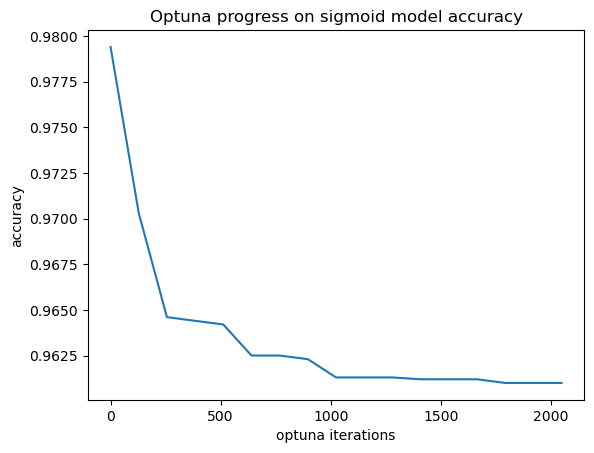

base-model accuracy:0.9789
2048-optuna-iterations-model accuracy:0.961
difference:0.0179


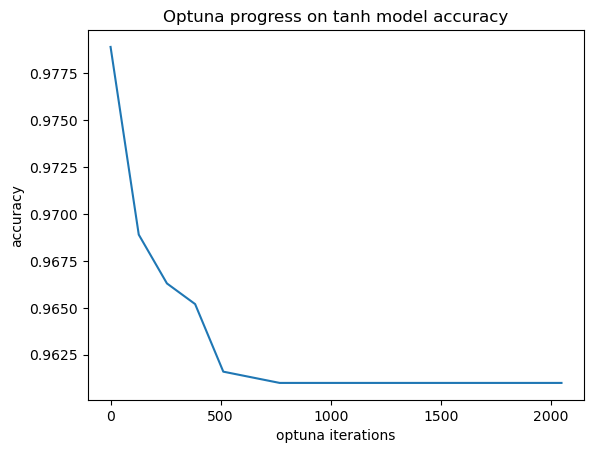

base-model accuracy:0.9816
2048-optuna-iterations-model accuracy:0.9671
difference:0.0145


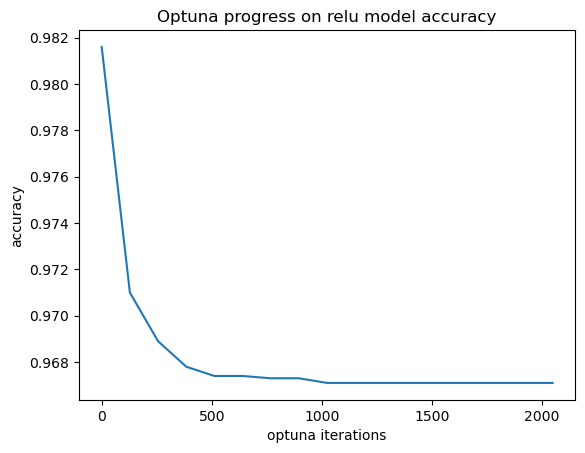

base-model accuracy:0.9779
2048-optuna-iterations-model accuracy:0.9568
difference:0.0211


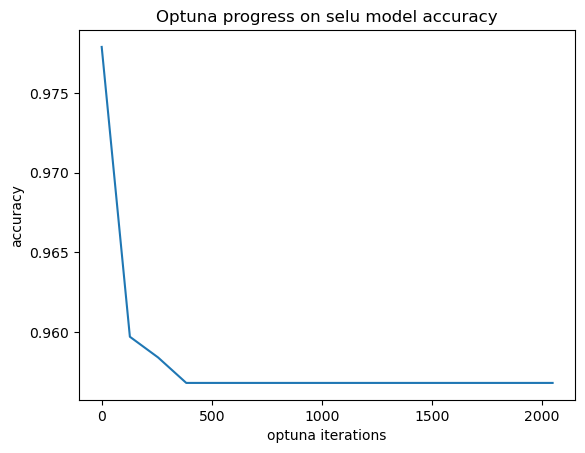

base-model accuracy:0.9761
2048-optuna-iterations-model accuracy:0.954
difference:0.0221


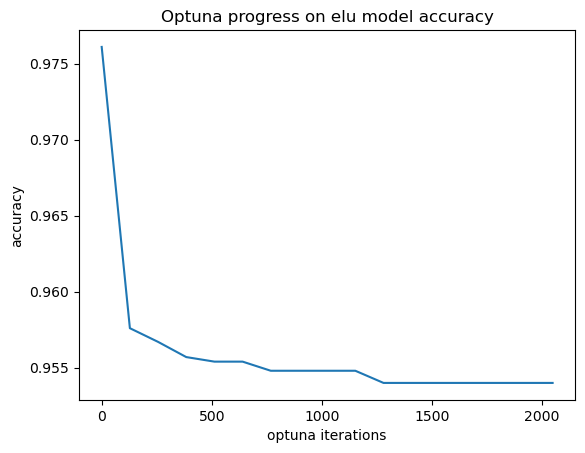

base-model accuracy:0.9756
2048-optuna-iterations-model accuracy:0.9596
difference:0.0160


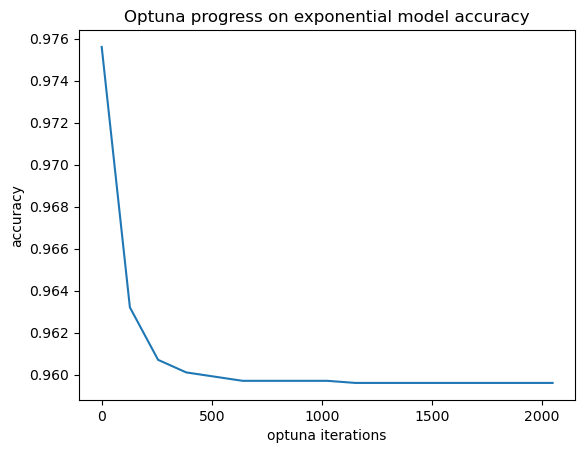

base-model accuracy:0.9808
2048-optuna-iterations-model accuracy:0.9695
difference:0.0113


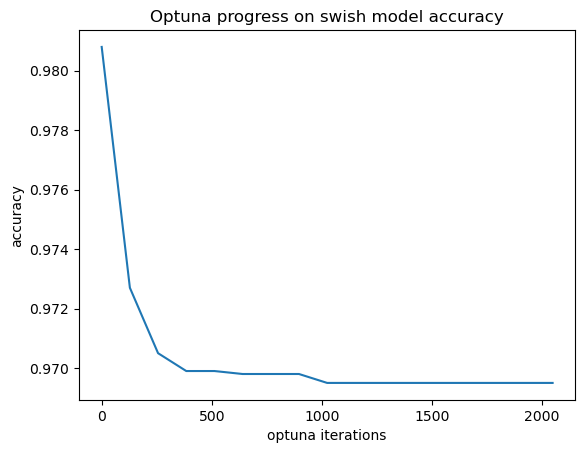

In [4]:
for function, initializer in DEEP_ACTIVATION.items():
    d = load_object(f"./scores/acc_trend_{function}")
    keys = np.fromiter(d.keys(), dtype=int)
    vals = np.fromiter(d.values(), dtype=float)
    print(f"base-model accuracy:{vals[0]}\n2048-optuna-iterations-model accuracy:{vals[-1]}\ndifference:%.4f" % (vals[0]-vals[-1]))

    plt.plot(keys, vals, label = "line 1")
    plt.title(f'Optuna progress on {function} model accuracy')
    plt.xlabel('optuna iterations')
    plt.ylabel('accuracy')
    plt.show()

#### Best attack for each function

index=4347 value=0.8993539214134216


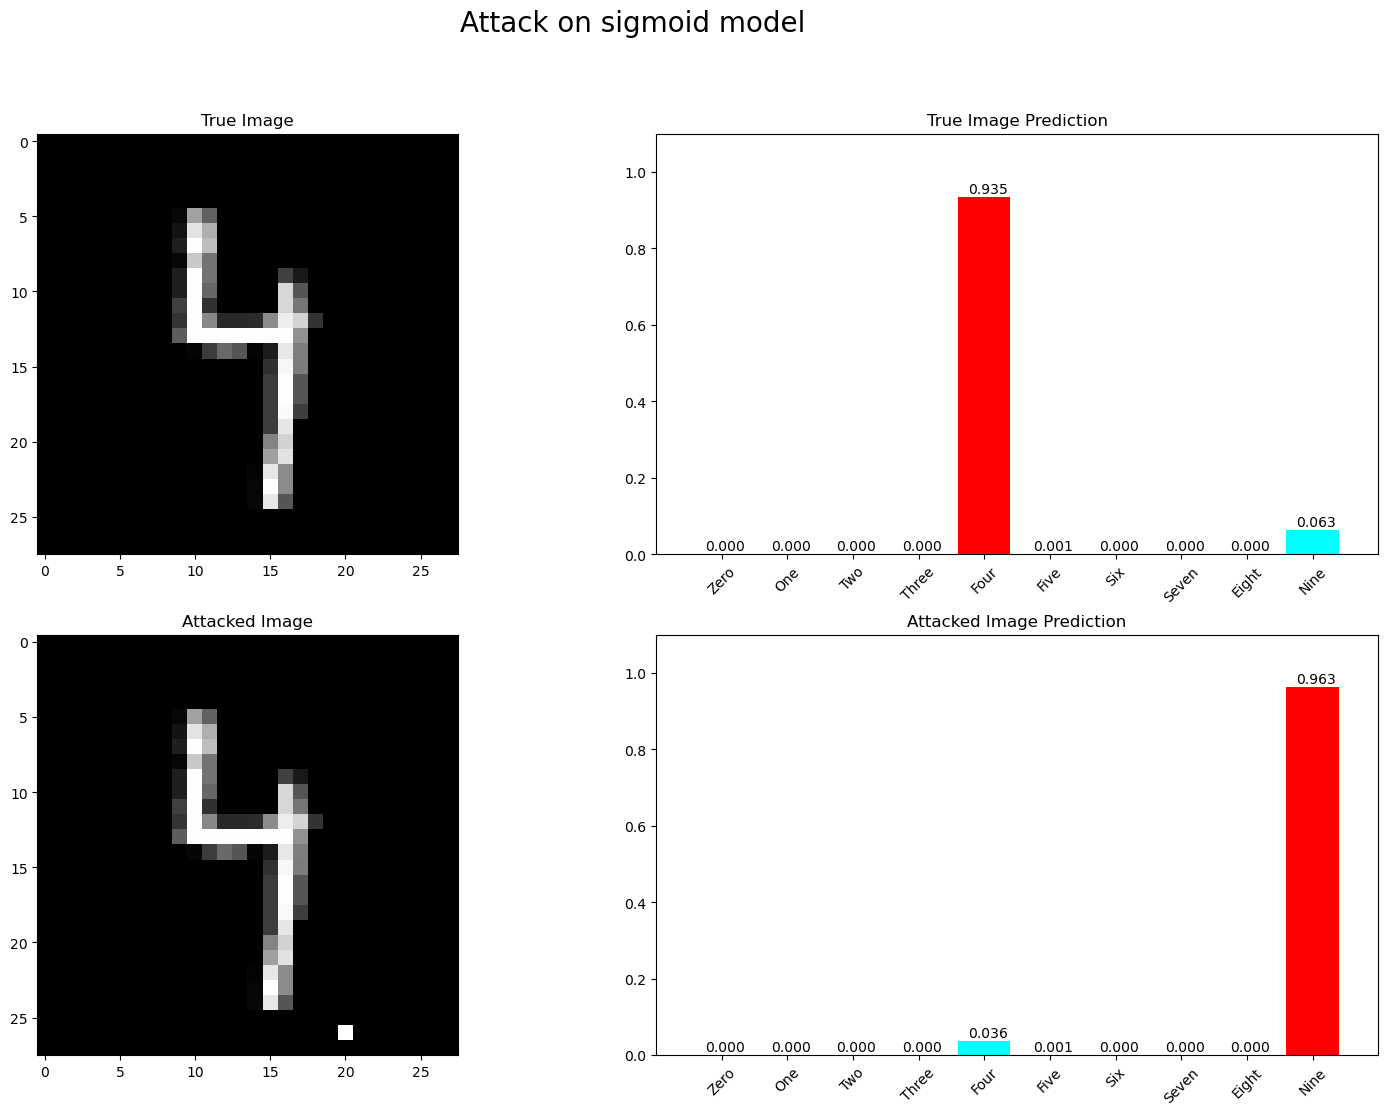

index=4875 value=0.8069798350334167


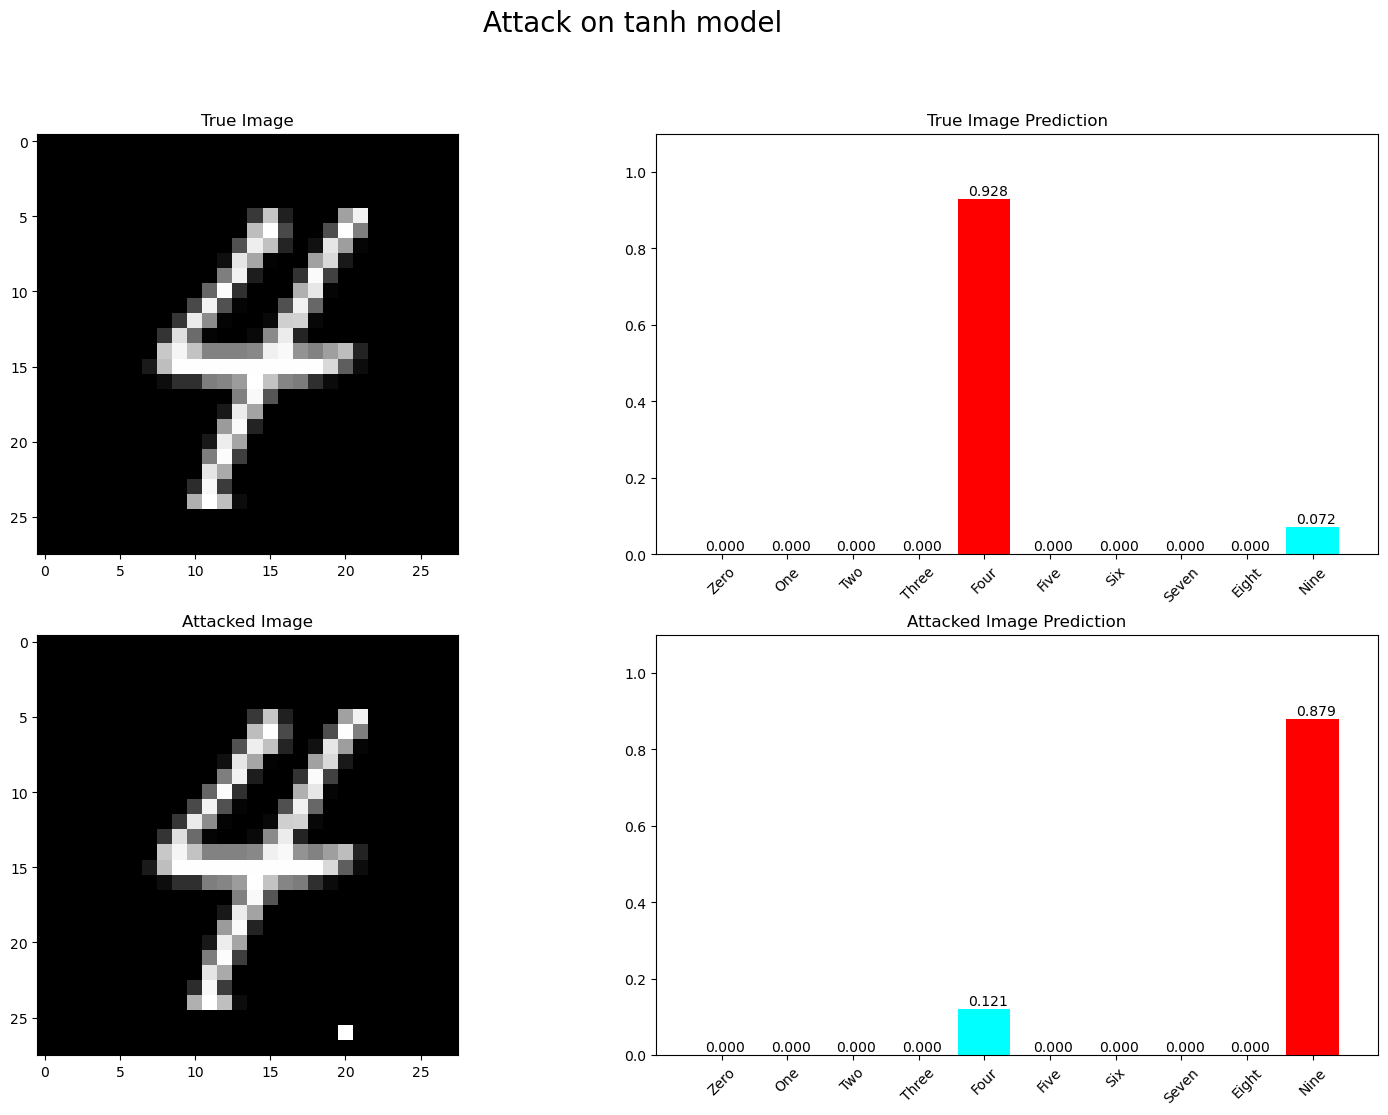

index=3809 value=0.7141966819763184


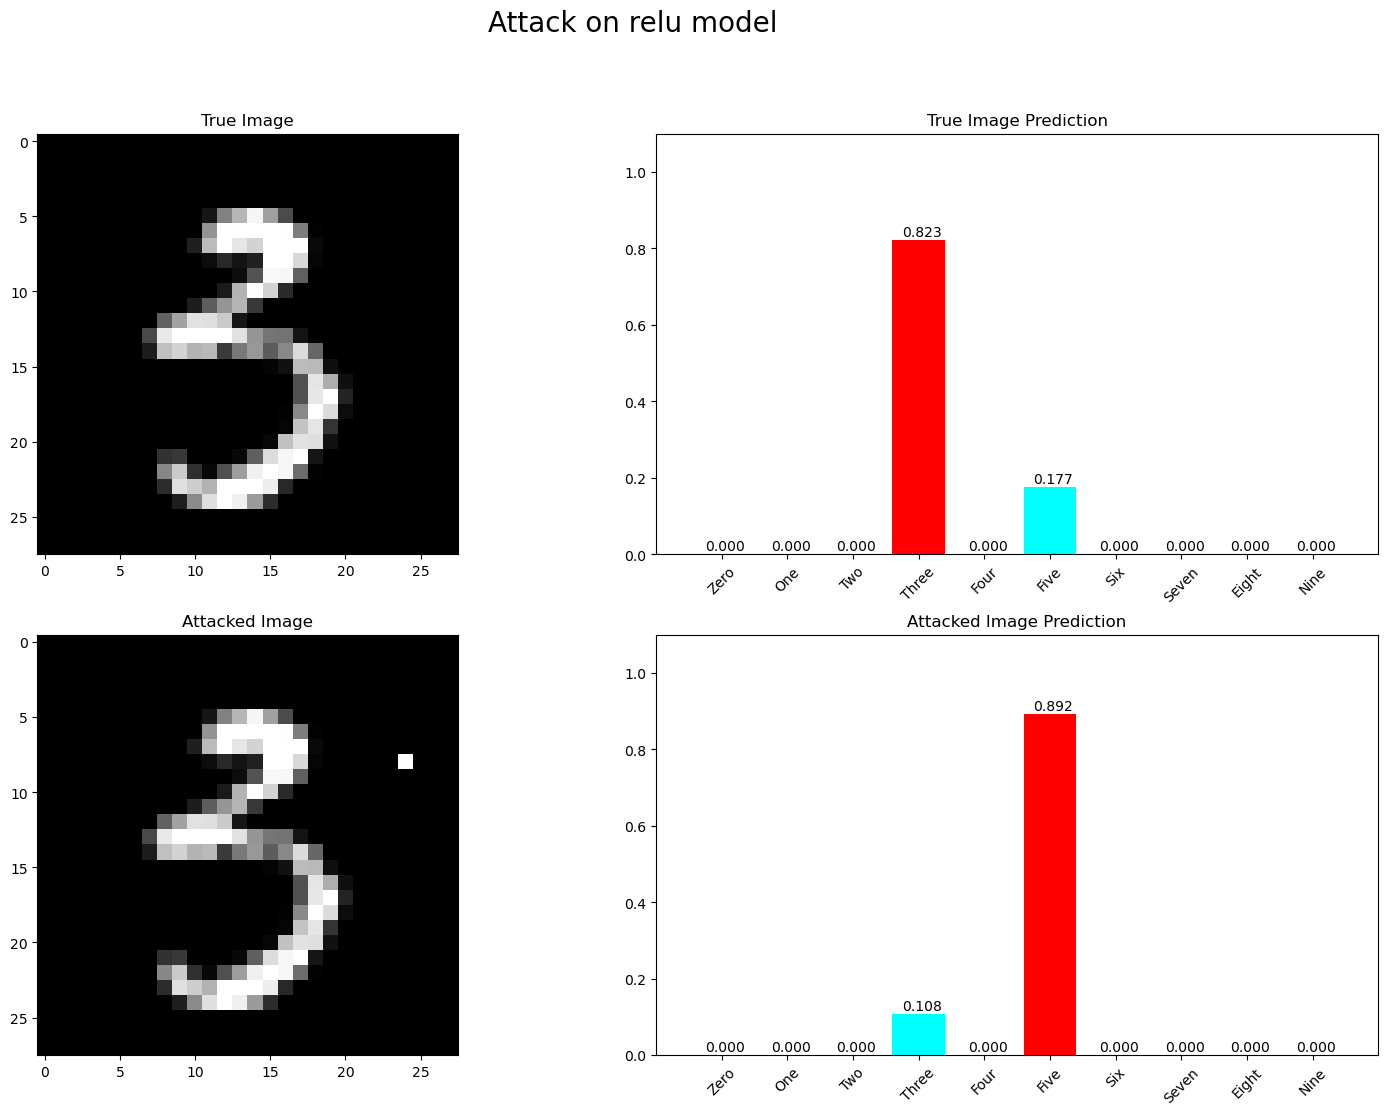

index=4347 value=0.901530385017395


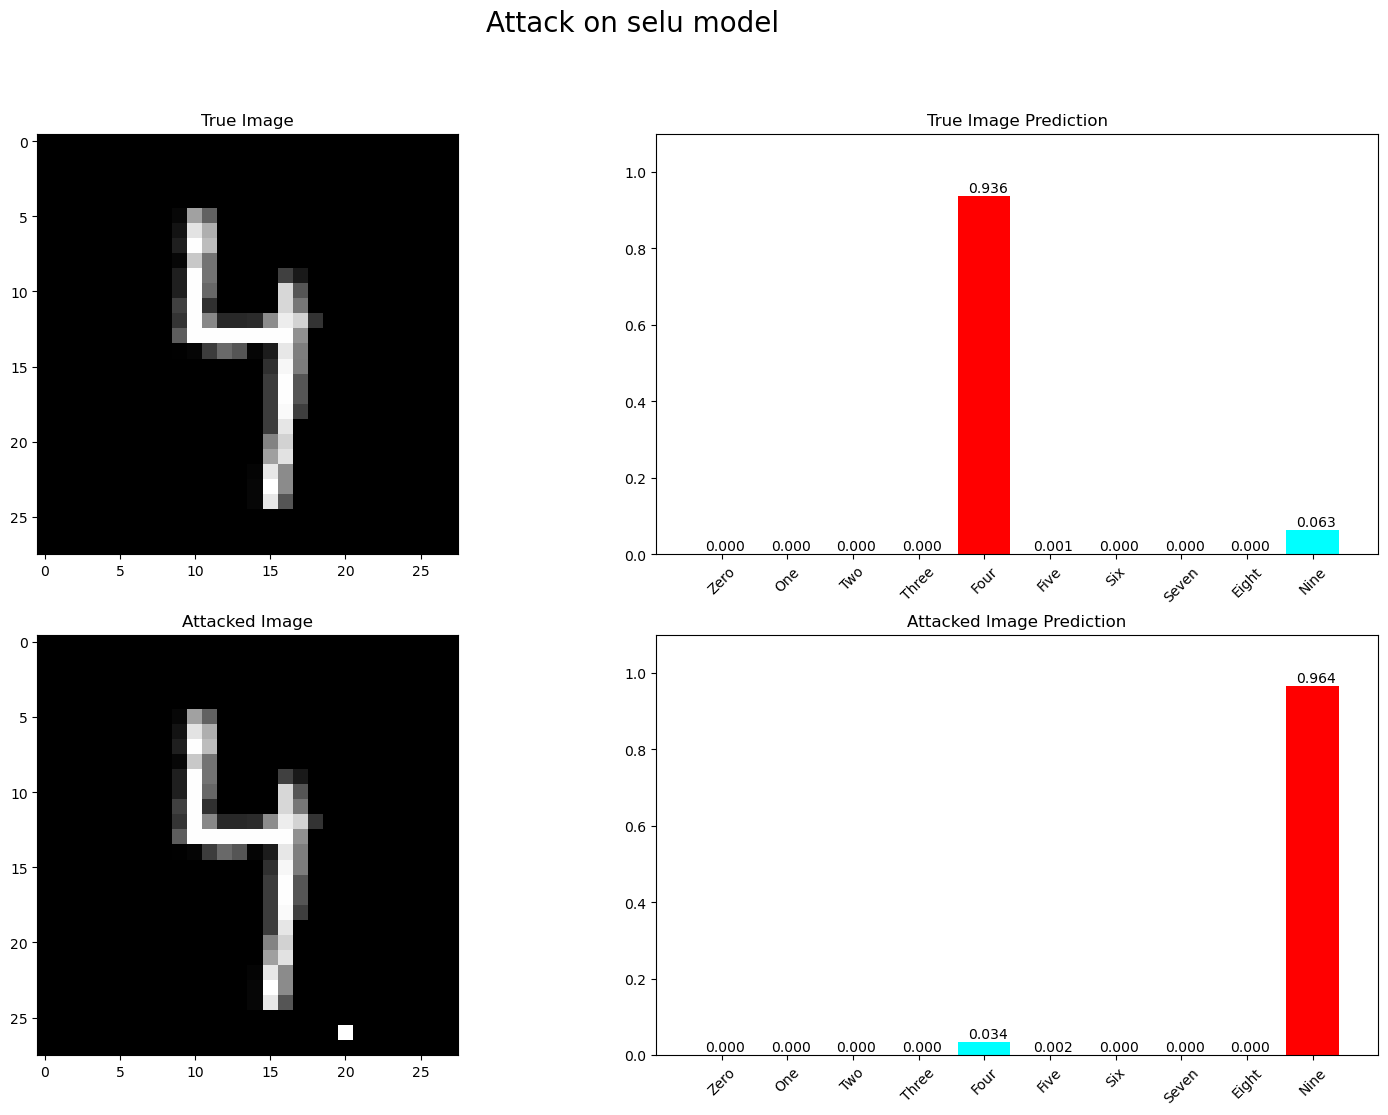

index=4167 value=0.8123602867126465


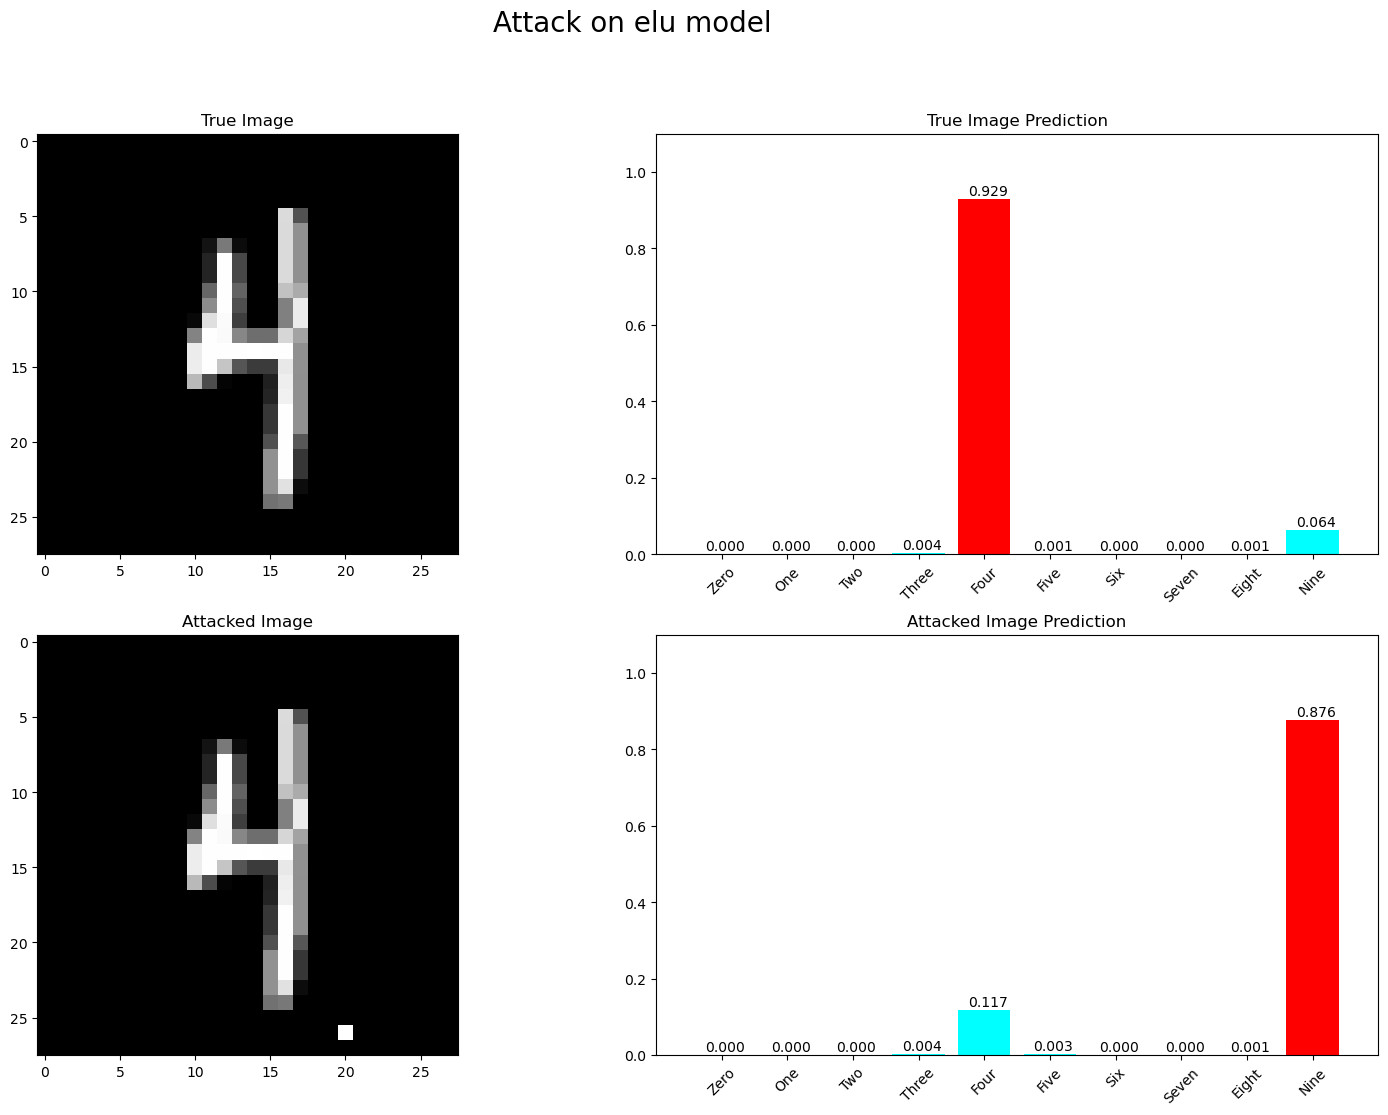

index=4648 value=0.8492294549942017


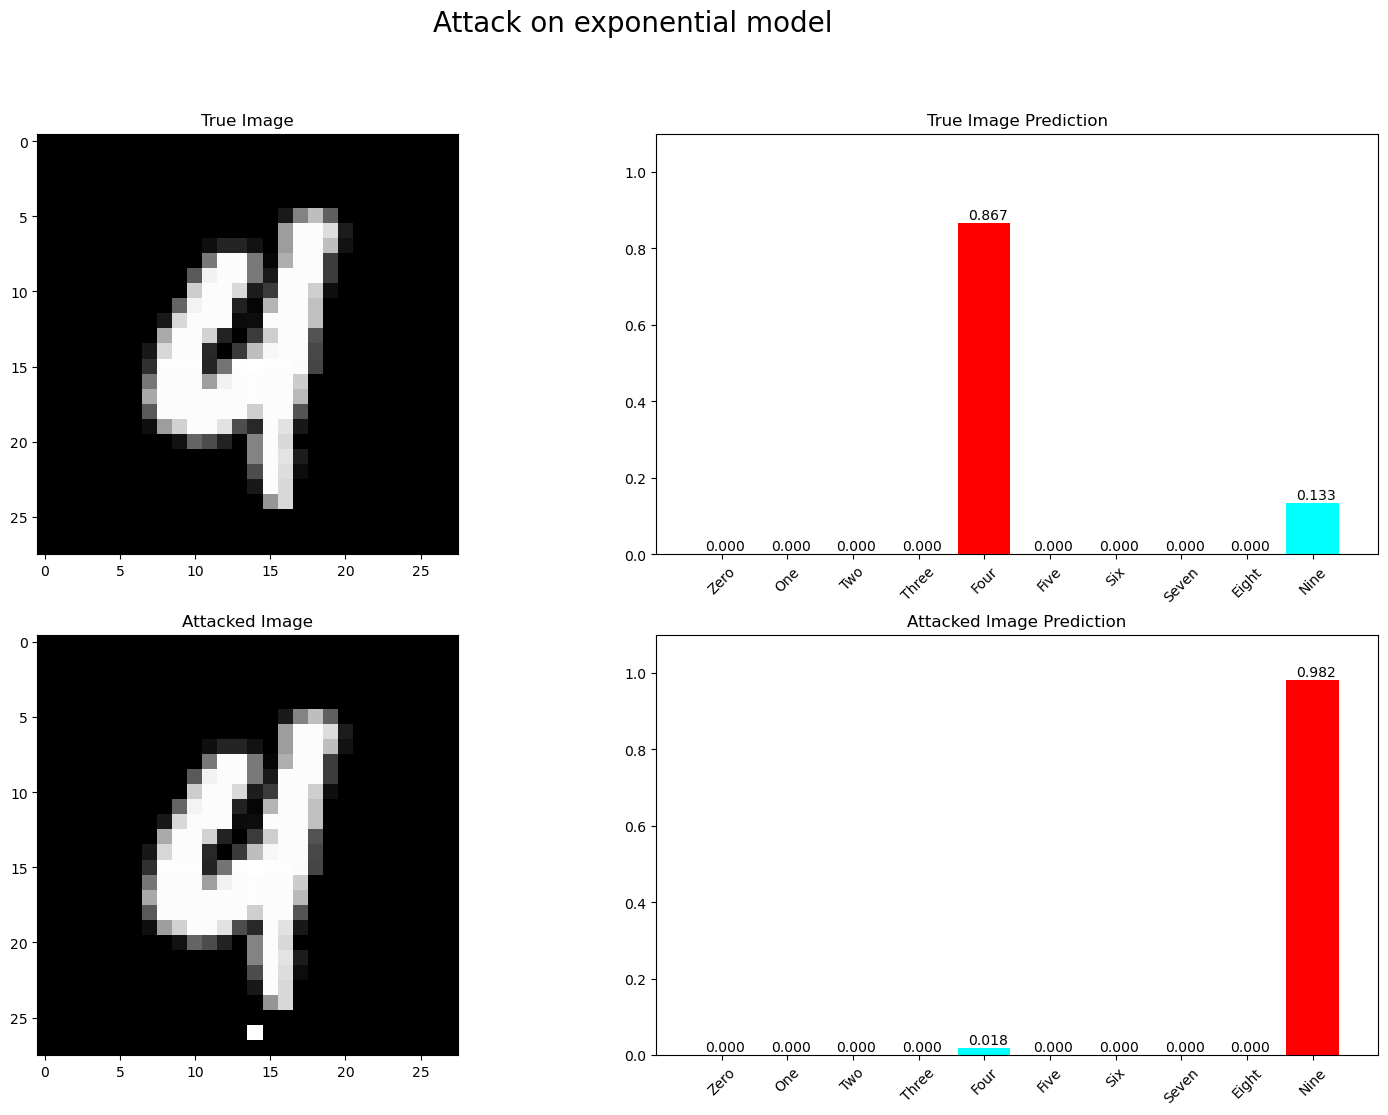

index=4450 value=0.7221909761428833


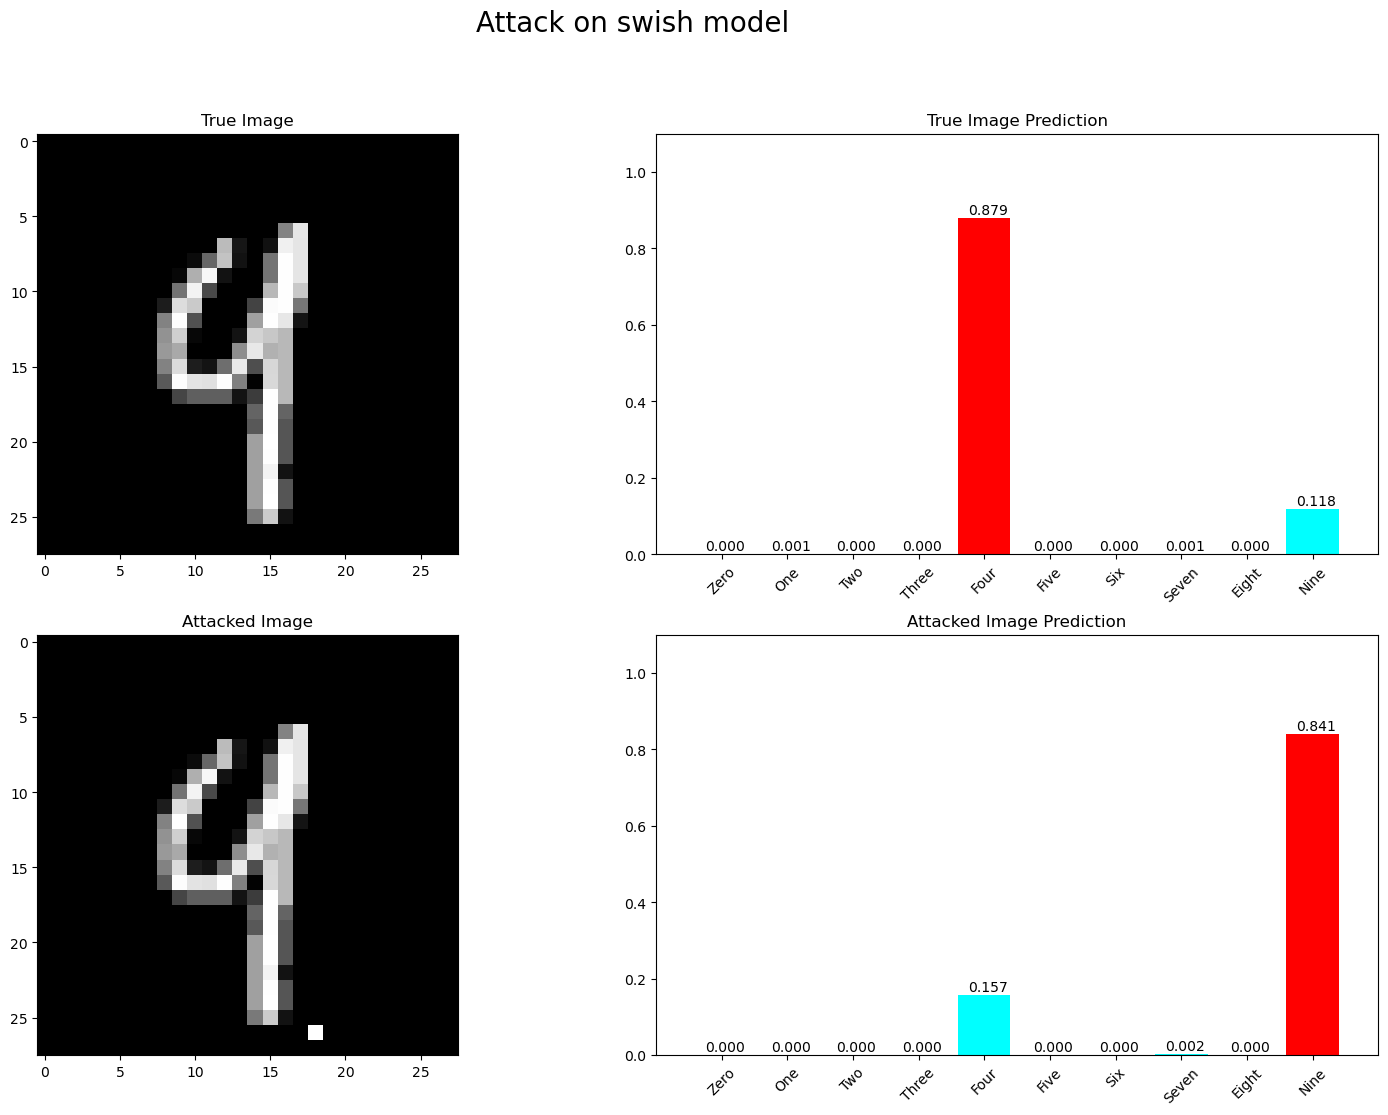

In [5]:
for function, initializer in DEEP_ACTIVATION.items():
    m1 = load_object(SCORES_PATH+"/scores_best_"+function)
    m2 = load_object(SCORES_PATH+"/scores_best_"+function+"_best_attack")
    m = load_model(MODELS_PATH+"/best_"+function+".h5")
    best_attack = 0
    maximum = 0
    for i in range (len(m1.y_true)): # per ogni immagine
        j = np.nonzero(m1.y_true[i])[0][0] # predizione vera
        k = abs(m1.y_pred[i][j] - m2.y_pred[i][j])
        if k >= maximum:
            maximum = k
            best_attack = i

    print(f"index={best_attack} value={maximum}")
    plot_attack(m1.x_test[best_attack], m2.x_test[best_attack], m, function)